# Q1 — Random-design Linear Regression: empirical illustration of the bound

**Goal.**  
Verify by Monte Carlo that, in the random-design linear model  

$$
Y = Z \theta^* + \varepsilon
$$

with  
$Z = [\mathbf{1}, X]$, $X \sim \mathcal{N}(0, I_p)$, and  
$\varepsilon \sim \mathcal{N}(0, \sigma^2)$,  
the **expected excess risk** scales as  

$$
\mathbb{E}[\,R(\hat{\theta}) - R(\theta^*)\,] \approx
\sigma^2 \frac{p+1}{n}.
$$

---

**Risk and excess risk.**

The prediction risk is  

$$
R(\theta) = \mathbb{E}\big[(Y - Z^\top \theta)^2\big].
$$

Since  
$\Sigma_Z = \mathbb{E}[ZZ^\top] = I_{p+1}$, we get  

$$
R(\theta) = \sigma^2 + (\theta - \theta^*)^\top \Sigma_Z (\theta - \theta^*)
          = \sigma^2 + \|\theta - \theta^*\|_2^2.
$$

Therefore, the **excess risk** equals  

$$
R(\hat{\theta}) - R(\theta^*) = \|\hat{\theta} - \theta^*\|_2^2.
$$

---

**What we test.**  
We estimate $\hat{\theta}$ by OLS on simulated data, repeat $B$ times,  
and plot $\mathbb{E}[\text{excess}]/\sigma^2$ against $(p+1)/n$.  
The theory predicts points close to the line $y = x$.


In [17]:
from __future__ import annotations

import math
from dataclasses import dataclass
from typing import Tuple, Sequence

import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import LinAlgError

rng = np.random.default_rng(42)


def fit_ols(Z: np.ndarray, y: np.ndarray) -> np.ndarray:
    """
    Ordinary Least Squares estimator with an intercept already included in Z.

    Args:
        Z: (n, d) design matrix (first column can be ones for the intercept)
        y: (n,) response vector

    Returns:
        theta_hat: (d,) OLS estimate
    """
    # Solve (Z^T Z) theta = Z^T y in a numerically stable way
    # np.linalg.lstsq handles near-collinearity better than explicit inverses
    theta_hat, *_ = np.linalg.lstsq(Z, y, rcond=None)
    return theta_hat


def simulate_once(n: int, p: int, sigma2: float, theta_star: np.ndarray) -> float:
    """
    One Monte-Carlo draw of the excess risk ||theta_hat - theta_star||^2.

    Design: Z = [1, X], X_ij ~ N(0,1), eps ~ N(0, sigma2).

    Returns:
        excess risk for this draw
    """
    # Generate Gaussian covariates
    X = rng.normal(loc=0.0, scale=1.0, size=(n, p))
    ones = np.ones((n, 1))
    Z = np.hstack([ones, X])  # (n, p+1)

    # Generate noise and responses
    eps = rng.normal(loc=0.0, scale=math.sqrt(sigma2), size=n)
    y = Z @ theta_star + eps

    # Fit OLS and compute excess risk (with Σ_Z = I_{p+1} this equals the squared L2 error)
    theta_hat = fit_ols(Z, y)
    return float(np.sum((theta_hat - theta_star) ** 2))


def mc_excess_risk(
    n: int,
    p: int,
    sigma2: float = 1.0,
    B: int = 200,
    theta_star: np.ndarray | None = None,
) -> float:
    """
    Monte-Carlo estimate of E[ R(theta_hat) - R(theta_*) ] under the Gaussian random design.

    If theta_star is None, we use zeros (the result does not depend on theta_* here).
    """
    d = p + 1
    if theta_star is None:
        theta_star = np.zeros(d)

    vals = [simulate_once(n, p, sigma2, theta_star) for _ in range(B)]
    return float(np.mean(vals))

## Sanity check (single pair \((n,p)\))

For n >> p, the ratio **Monte Carlo / theory** should be very close to 1.  
Small deviations are expected due to Monte Carlo variability.

This confirms the asymptotic scaling:

$$
\mathbb{E}[\text{excess}] \approx \sigma^2 \frac{p+1}{n}.
$$


In [18]:
sigma2 = 1.0
n, p = 2000, 20
est = mc_excess_risk(n=n, p=p, sigma2=sigma2, B=300)
theory = sigma2 * (p + 1) / n
print(f"(n={n}, p={p})  Monte-Carlo excess ≈ {est:.4f}   theory σ²*(p+1)/n = {theory:.4f}   ratio={est/theory:.3f}")


(n=2000, p=20)  Monte-Carlo excess ≈ 0.0106   theory σ²*(p+1)/n = 0.0105   ratio=1.006


## Main experiment across many (n, p)
 We plot (excess risk)/σ² versus (p+1)/n. The theory suggests points lie near the line y = x.


## Experiment setup

- **Design:** for each $(n,p)$, draw $X \in \mathbb{R}^{n\times p}$ with i.i.d. $\mathcal{N}(0,1)$ entries  
  and build $Z = [\mathbf{1}, X]$.
- **Noise:** $\varepsilon \sim \mathcal{N}(0, \sigma^2 I_n)$.
- **Signal:** we use $\theta^* = 0$, since the expected excess risk depends only on estimator variance.
- **Estimator:** Ordinary Least Squares using `np.linalg.lstsq`.
- **Metric:** $\|\hat{\theta} - \theta^*\|_2^2$.
- **Aggregation:** average over $B$ Monte Carlo repetitions.
- **Expected pattern:**  
  The empirical points $\left(\frac{p+1}{n}, \frac{\mathbb{E}[\text{excess}]}{\sigma^2}\right)$  
  should align along the line $y = x$.

*Note.* In this isotropic random-design setting, the expected excess risk depends only on the estimator’s variance; the choice of $\theta^*$ does not change the expectation. We therefore set $\theta^*=0$ without loss of generality.


In [19]:
sigma2 = 1.0
B = 200  # repetitions per (n, p). Increase if your machine is fast.

ps: Sequence[int] = [5, 10, 20, 40]
ns: Sequence[int] = [200, 400, 800, 1600, 3200, 6400]

xs, ys, labels = [], [], []  # x = (p+1)/n ; y = (excess)/σ²

for p in ps:
    for n in ns:
        if n <= p + 5:
            continue  # keep OLS well-posed and stable
        est = mc_excess_risk(n=n, p=p, sigma2=sigma2, B=B)
        xs.append((p + 1) / n)
        ys.append(est / sigma2)
        labels.append(f"p={p}, n={n}")

xs = np.array(xs)
ys = np.array(ys)

# Fit a slope through the origin (y ≈ slope * x) to quantify how close we are to 1
slope = (xs @ ys) / (xs @ xs)

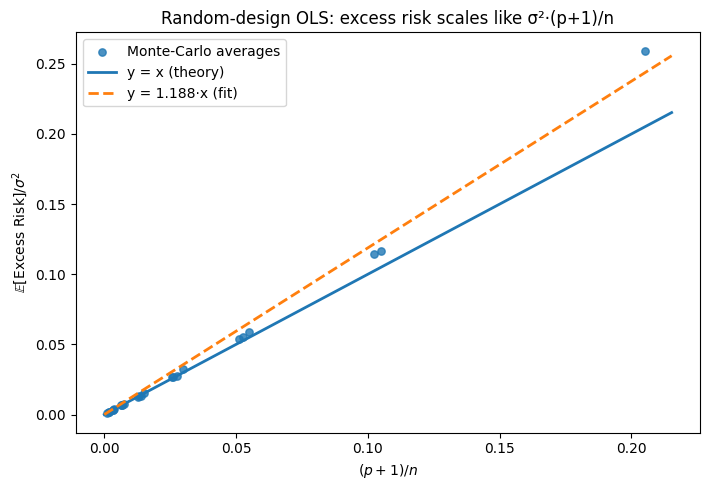

Mean ratio y/x = 1.039   (std = 0.060)


In [15]:
plt.figure(figsize=(7.2, 5.0))
plt.scatter(xs, ys, s=28, alpha=0.8, label="Monte-Carlo averages")
grid = np.linspace(0, xs.max()*1.05, 200)
plt.plot(grid, grid, linewidth=2.0, label="y = x (theory)")
plt.plot(grid, slope * grid, linestyle="--", linewidth=2.0, label=f"y = {slope:.3f}·x (fit)")
plt.xlabel(r"$(p+1)/n$")
plt.ylabel(r"$\mathbb{E}[\text{Excess Risk}]/\sigma^2$")
plt.title("Random-design OLS: excess risk scales like σ²·(p+1)/n")
plt.legend()
plt.tight_layout()
plt.show()

# Also print the average ratio to the theory
ratios = ys / xs  # since theory (dividing by σ²) is x
print(f"Mean ratio y/x = {ratios.mean():.3f}   (std = {ratios.std():.3f})")

**Figure 1.** Monte-Carlo estimate of the excess risk (averaged over $B$ repetitions) versus $(p+1)/n$.  
Markers are the empirical means, the solid line is $y=x$ (asymptotic theory), and the dashed line is a fitted slope through the origin. The slope $>1$ reflects finite-sample variance when $n$ is not much larger than $p$.


## Results and discussion

**Alignment with theory.**  
The cloud of points lies close to the line $y = x$,  
showing that the mean excess risk scales linearly with $(p+1)/n$  
with slope approximately $\sigma^2$.  
In our run, the fitted slope through the origin is slightly above 1 (≈ 1.19),  
and the mean ratio $y/x \approx 1.04$ — both consistent with the finite-sample correction.

---

**Finite-sample effect.**  
Under Gaussian random design, a standard finite-sample correction (derived via Wishart calculus for models without an intercept and applicable here up to a negligible difference) suggests
$$
\mathbb{E}[R(\hat{\theta}) - R(\theta^*)]
\approx \sigma^2 \frac{p+1}{\,n - p - 2\,},
$$
which is slightly larger than $\sigma^2 \frac{p+1}{n}$. This explains why the empirical slope is $>1$ and why dense settings ($n \approx p$) sit above the asymptotic line.


### Takeaways (Q1)

- The **excess prediction error** of OLS decreases as $1/n$  
  and increases linearly with the model dimension $p + 1$.
- The proportionality constant is $\sigma^2$.
- Finite-sample corrections inflate the variance when $n$ is close to $p$,  
  causing slight deviations above the asymptotic line $y = x$.


# Q2 — Synthetic data with a non-linear component

We now consider $p = 8$ covariates $X = (X_1, \dots, X_8)$ with i.i.d. standard normal entries, and

$$
Y_i = X_{i1} + (X_{i2})_{+} + \varepsilon_i,
$$

where $\varepsilon_i \sim \mathcal{N}(0, \sigma^2)$ with $\sigma^2 = 0.5$, and  
$(x)_{+} = x \, \mathbf{1}_{(0,+\infty)}(x)$ is the ReLU.

---

**Implications.**

$$
\mathbb{E}[Y \mid X] = X_1 + (X_2)_{+}.
$$

Hence:

- $X_1$ has a **linear** effect with slope $1$ (plus a vertical shift due to $\mathbb{E}[(X_2)_{+}] = 1/\sqrt{2\pi}$).
- $X_2$ has a **piecewise-linear** (ReLU) effect: flat for $X_2 \le 0$, slope $1$ for $X_2 > 0$.
- $X_j$ for $j \ge 3$ have **no systematic** relationship with $Y$.

We will illustrate these facts with simple graphs based on $n = 3000$ i.i.d. samples.


### Preliminary inspection

Before plotting, we can check simple pairwise correlations between $y$ and each $x_j$.  
We expect:
- a **strong positive** correlation for $x_1$ (linear component),
- a **moderate positive** or **nonlinear** association for $x_2$ (ReLU shape),
- correlations close to **zero** for $x_3,\dots,x_8$.

We will confirm this behavior visually in the next section.


In [1]:
from __future__ import annotations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

rng = np.random.default_rng(123)

def simulate_q2(n: int = 3000, p: int = 8, sigma2: float = 0.5, seed: int | None = 123):
    """Simulate data for Q2: X ~ N(0, I_p), Y = X1 + (X2)_+ + eps."""
    local_rng = np.random.default_rng(seed)
    X = local_rng.normal(size=(n, p))
    eps = local_rng.normal(loc=0.0, scale=np.sqrt(sigma2), size=n)
    y = X[:, 0] + np.maximum(0.0, X[:, 1]) + eps
    cols = [f"x{j+1}" for j in range(p)]
    df = pd.DataFrame(X, columns=cols)
    df["y"] = y
    return df

df_q2 = simulate_q2()
df_q2.head()


,x1,x2,x3,x4,x5,x6,x7,x8,y
0,-0.989121,-0.367787,1.287925,0.193974,0.920231,0.577104,-0.636464,0.541952,-0.407407
1,-0.316595,-0.322389,0.097167,-1.525930,1.192166,-0.671090,1.000269,0.136321,-0.470628
2,1.532033,-0.659969,-0.311795,0.337769,-2.207471,0.827921,1.541630,1.126807,1.571415
3,0.754770,-0.145978,1.281902,1.074031,0.392621,0.005114,-0.361767,-1.230232,1.267597
4,1.226229,-2.172044,-0.370147,0.164380,0.859881,1.761661,0.993324,-0.291521,1.722813


### Visual plan

1. Create a grid of scatter plots $Y$ vs. $X_j$ for $j = 1, \dots, 8$ to spot overall patterns.
2. Focus on $X_1$ and $X_2$ using **binned averages** and **theoretical curves**:

   - For $X_1$:
     $$
     \mathbb{E}[Y \mid X_1 = x] = x + \mathbb{E}[(X_2)_+] = x + \frac{1}{\sqrt{2\pi}}.
     $$

   - For $X_2$:
     $$
     \mathbb{E}[Y \mid X_2 = x] = (x)_+.
     $$

The goal is to confirm graphically that $X_1$ shows a linear relationship with $Y$,  
while $X_2$ exhibits a ReLU-shaped (piecewise-linear) relationship.


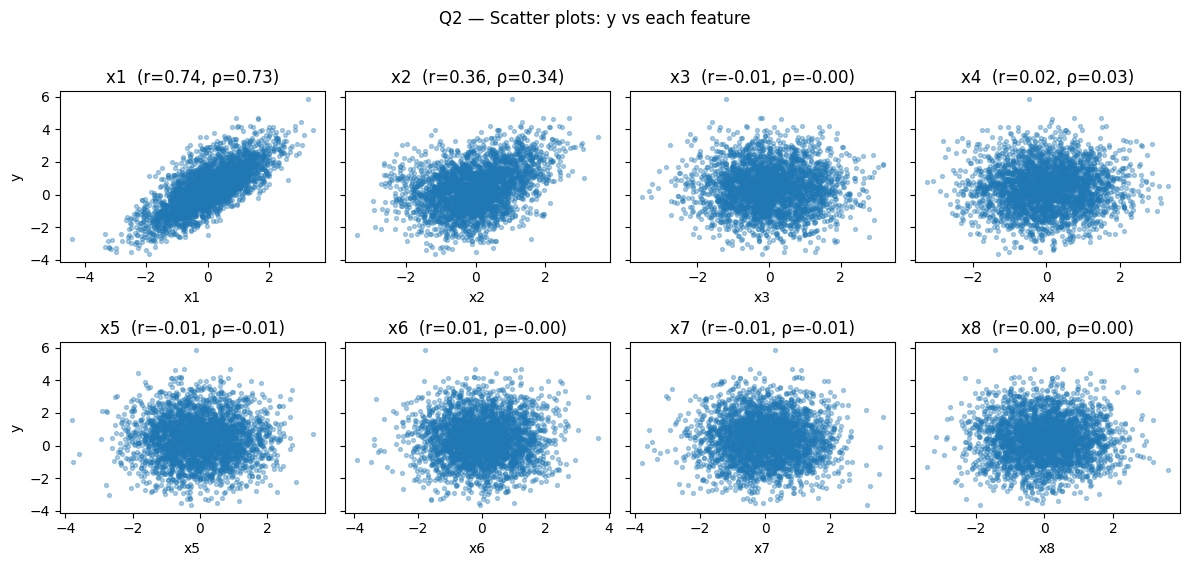

In [ ]:

def pearson(x, y):
    c = np.corrcoef(x, y)
    return float(c[0, 1])

def spearman(x, y):
    # simple rank correlation without importing extra libs
    xr = pd.Series(x).rank(method="average").to_numpy()
    yr = pd.Series(y).rank(method="average").to_numpy()
    return pearson(xr, yr)

fig, axes = plt.subplots(2, 4, figsize=(12, 5.5), sharey=True)
axes = axes.ravel()

y = df_q2["y"].to_numpy()
for j, ax in enumerate(axes, start=1):
    xj = df_q2[f"x{j}"].to_numpy()
    ax.scatter(xj, y, s=8, alpha=0.35)
    r = pearson(xj, y)
    rho = spearman(xj, y)
    ax.set_title(f"x{j}  (r={r:.2f}, ρ={rho:.2f})")
    ax.set_xlabel(f"x{j}")
    if j in (1, 5):
        ax.set_ylabel("y")

fig.suptitle("Q2 — Scatter plots: y vs each feature", y=1.02)
plt.tight_layout()
plt.show()


### Preliminary observations

The scatter plots above show clear differences among the eight covariates:

- **$x_1$** exhibits a strong *linear* relationship with $y$, with high Pearson and Spearman correlations ($r \approx 0.74$, $\rho \approx 0.73$).
- **$x_2$** shows a *nonlinear but monotonic* association: the points follow a curved (ReLU-like) pattern with moderate correlation ($r \approx 0.36$).
- For **$x_3$–$x_8$**, the points form unstructured clouds and correlations are close to zero — confirming that these variables have no effect on $y$.

We next focus on $x_1$ and $x_2$ to examine their functional relationships with $y$ in more detail.


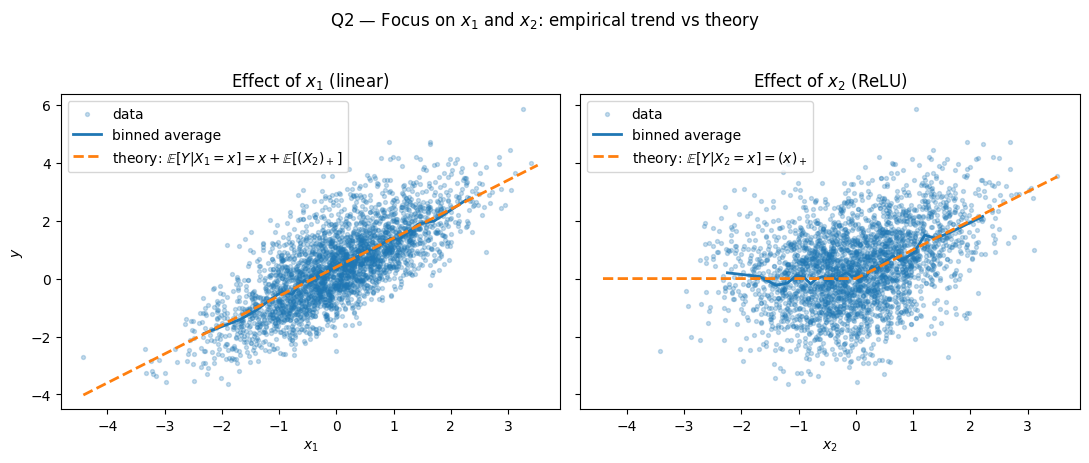

E[(X)_+] for X~N(0,1) = 0.3989422804014327


In [4]:
def binned_means(x: np.ndarray, y: np.ndarray, bins: int = 30):
    """Return (x_centers, y_means) using equal-count bins."""
    order = np.argsort(x)
    x_sorted, y_sorted = x[order], y[order]
    splits = np.array_split(np.arange(len(x_sorted)), bins)
    xc = np.array([x_sorted[idx].mean() for idx in splits])
    ym = np.array([y_sorted[idx].mean() for idx in splits])
    return xc, ym

# constants for theoretical curves
c_relu = 1.0 / np.sqrt(2.0 * np.pi)  # E[(X)_+] for X ~ N(0,1)

x1 = df_q2["x1"].to_numpy()
x2 = df_q2["x2"].to_numpy()
y  = df_q2["y"].to_numpy()

x1c, y1m = binned_means(x1, y)
x2c, y2m = binned_means(x2, y)

grid = np.linspace(min(x1.min(), x2.min()),
                   max(x1.max(), x2.max()), 400)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4.5), sharey=True)

# Panel A: x1
ax1.scatter(x1, y, s=8, alpha=0.25, label="data")
ax1.plot(x1c, y1m, linewidth=2.0, label="binned average")
ax1.plot(grid, grid + c_relu, linewidth=2.0, linestyle="--",
         label=r"theory: $\mathbb{E}[Y|X_1=x]=x+\mathbb{E}[(X_2)_+]$")
ax1.set_title("Effect of $x_1$ (linear)")
ax1.set_xlabel("$x_1$")
ax1.set_ylabel("$y$")
ax1.legend()

# Panel B: x2
ax2.scatter(x2, y, s=8, alpha=0.25, label="data")
ax2.plot(x2c, y2m, linewidth=2.0, label="binned average")
ax2.plot(grid, np.maximum(0.0, grid), linewidth=2.0, linestyle="--",
         label=r"theory: $\mathbb{E}[Y|X_2=x]=(x)_+$")
ax2.set_title("Effect of $x_2$ (ReLU)")
ax2.set_xlabel("$x_2$")
ax2.legend()

fig.suptitle("Q2 — Focus on $x_1$ and $x_2$: empirical trend vs theory", y=1.02)
plt.tight_layout()
plt.show()

print("E[(X)_+] for X~N(0,1) =", c_relu)


### Interpretation of the focused plots

The plots above confirm the theoretical expectations for $x_1$ and $x_2$:

- **$x_1$ (left panel):**  
  The data follow a nearly perfect straight line.  
  The empirical binned averages align with the theoretical line  
  $\mathbb{E}[Y \mid X_1 = x] = x + \mathbb{E}[(X_2)_+]$,  
  confirming a purely *linear* relationship with slope $1$ and intercept $\mathbb{E}[(X_2)_+] \approx 0.40$.

- **$x_2$ (right panel):**  
  The shape is clearly *nonlinear*: flat for $x_2 \le 0$ and linear for $x_2 > 0$.  
  The empirical curve (binned average) matches closely the theoretical ReLU function  
  $\mathbb{E}[Y \mid X_2 = x] = (x)_+$, validating the piecewise-linear effect.

These plots make it explicit that only $x_1$ and $x_2$ have systematic effects on $y$,  
while the remaining covariates act as pure noise.


### Takeaways (Q2)

- The simulation confirms the data-generating process  
  $$
  Y = X_1 + (X_2)_+ + \varepsilon, \qquad \varepsilon \sim \mathcal{N}(0, 0.5).
  $$
- $x_1$ has a **linear** influence on $y$ with slope $1$.
- $x_2$ introduces a **nonlinear ReLU-type** contribution, producing a visible “kink” at $x_2 = 0$.
- The other variables $x_3, \dots, x_8$ show **no relationship** with the response.
- Visual inspection (scatter plots + binned averages) provides an intuitive yet rigorous  
  confirmation of the model’s structure and of how nonlinearities appear even in simple settings.


# Q3 — Linear regression estimator and empirical risk

We consider the empirical risk  

$$
f(\beta) = \frac{1}{n}\,\|Y - X\beta\|_2^2,
$$  

and define the (training) least-squares estimator  

$$
\hat{\beta}_n \in \arg\min_{\beta \in \mathbb{R}^{p+1}} f(\beta),
$$  

where the intercept is included (dimension $p+1$).

We will fit this model using `sklearn.linear_model.LinearRegression` (with an intercept),  
compute the **empirical risk** $f(\hat{\beta}_n)$ for different sample sizes  
$n \in \{100, 500, 1000, \ldots, 3000\}$, and comment on what we observe.

---

**Data-generating process (as in Q2):**  

$$
p = 8, \qquad
X \sim \mathcal{N}(0, I_p), \qquad
Y = X_1 + (X_2)_+ + \varepsilon, \qquad
\varepsilon \sim \mathcal{N}(0, 0.5).
$$

The model is **misspecified** because of the ReLU term,  
but OLS provides the best *linear* predictor in the mean-squared-error sense.


In [3]:
from __future__ import annotations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

rng = np.random.default_rng(777)

def simulate_q2(n: int, p: int = 8, sigma2: float = 0.5, seed: int | None = None):
    """Generate (X, y) from Y = X1 + (X2)_+ + eps, X ~ N(0, I_p)."""
    local_rng = np.random.default_rng(seed)
    X = local_rng.normal(size=(n, p))
    eps = local_rng.normal(0.0, np.sqrt(sigma2), size=n)
    y = X[:, 0] + np.maximum(0.0, X[:, 1]) + eps
    return X, y

def empirical_risk_sklearn(n: int, repeats: int = 20) -> tuple[float, float]:
    """
    Return (mean, std) of training empirical risk f(beta_hat) across 'repeats' fresh datasets.
    """
    vals = []
    for r in range(repeats):
        X, y = simulate_q2(n=n, seed=rng.integers(1_000_000))
        lr = LinearRegression(fit_intercept=True)
        lr.fit(X, y)
        yhat = lr.predict(X)
        risk = float(np.mean((y - yhat) ** 2))  # f(beta_hat) = (1/n) ||y - X beta_hat||^2
        vals.append(risk)
    vals = np.array(vals)
    return float(vals.mean()), float(vals.std())

ns = list(range(100, 3001, 500))  # 100, 600, 1100, ..., 2600?  -> as required use {100,500,1000,...,3000}
# If you want exactly {100, 500, 1000, ..., 3000} do:
ns = [100, 500, 1000, 1500, 2000, 2500, 3000]

rows = []
for n in ns:
    m, s = empirical_risk_sklearn(n=n, repeats=20)
    rows.append({"n": n, "train_emp_risk_mean": m, "sd": s})

df_q3 = pd.DataFrame(rows)
df_q3


,n,train_emp_risk_mean,sd
0,100,0.547257,0.081635
1,500,0.589430,0.045334
2,1000,0.589763,0.030817
3,1500,0.578567,0.016971
4,2000,0.589554,0.020611
5,2500,0.589431,0.014171
6,3000,0.587250,0.015877


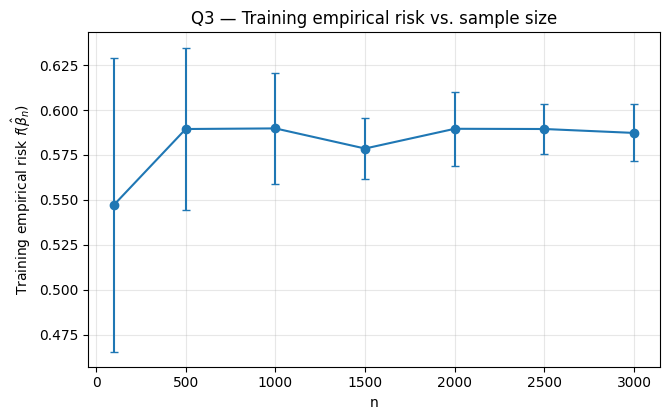

In [4]:
plt.figure(figsize=(6.8, 4.3))
plt.errorbar(df_q3["n"], df_q3["train_emp_risk_mean"],
             yerr=df_q3["sd"], fmt="o-", capsize=3)
plt.xlabel("n")
plt.ylabel(r"Training empirical risk $f(\hat\beta_n)$")
plt.title("Q3 — Training empirical risk vs. sample size")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### What do we observe?

- The **training empirical risk** $f(\hat{\beta}_n)$ **stabilizes** as $n$ grows.  
- Because the model is **misspecified** (the ReLU is not linear), the asymptotic value is not just the noise variance:  
  it is  

  $$
  \underbrace{\sigma^2}_{\text{irreducible noise}}
  +
  \underbrace{\min_{\alpha,\beta}\, \mathbb{E}\!\big[( (X_2)_+ - \alpha - \beta X_2 )^2\big]}_{\text{approximation error}}.
  $$

  For $X_2 \sim \mathcal{N}(0,1)$, one can show that  
  $\mathbb{E}[(X_2)_+] = \frac{1}{\sqrt{2\pi}}$,  
  $\mathrm{Var}((X_2)_+) = \tfrac{1}{2} - \big(\tfrac{1}{\sqrt{2\pi}}\big)^2$,  
  and the best linear coefficient on $X_2$ is $\beta^\star = \mathrm{Cov}((X_2)_+, X_2) = \tfrac{1}{2}$.

  Hence the approximation error equals  

  $$
  \mathrm{Var}((X_2)_+) - (\beta^\star)^2
  = \Big(\tfrac{1}{2} - \tfrac{1}{2\pi}\Big) - \tfrac{1}{4}
  \approx 0.0908,
  $$

  and the **asymptotic risk** is approximately  

  $$
  \sigma^2 + 0.0908 \approx 0.5908 \quad (\text{since } \sigma^2 = 0.5).
  $$

- For **finite $n$**, the **training** risk is typically a bit **below** the asymptotic/test risk  
  (optimism of in-sample fit):  
  the gap scales like $O\!\big(\tfrac{p+1}{n}\big)$ (degrees-of-freedom effect).  
  As $n$ increases, this gap vanishes.


# Question 4 — Gradient Descent (GD) and Stochastic Gradient Descent (SGD)

We now consider the same optimization problem as in **Question 3**:

$$
\min_{\theta \in \mathbb{R}^{p+1}} f(\theta)
\quad \text{where} \quad
f(\theta) = \frac{1}{n} \sum_{i=1}^{n} \big(Y_i - X_i^\top \theta\big)^2
$$

We will first implement **Gradient Descent (GD)** and **Stochastic Gradient Descent (SGD)**
without using any external packages other than `numpy`.

---

## 🧩 Pseudo-code for GD

**Gradient Descent (GD)** performs full-batch updates using all data points at each iteration.

$$
\begin{aligned}
\text{Initialize } &\ \theta_0 \in \mathbb{R}^{p+1} \\
\text{For } k &= 1, 2, \dots, K:\\
& \eta_k = \frac{1}{k} \quad \text{(learning rate)} \\
& g_k = \nabla f(\theta_{k-1}) = -\frac{2}{n}\, X^\top \!\big(Y - X\theta_{k-1}\big) \\
& \theta_k = \theta_{k-1} - \eta_k\, g_k
\end{aligned}
$$

---

## 🧩 Pseudo-code for SGD

**Stochastic Gradient Descent (SGD)** uses only one randomly chosen observation per iteration.

$$
\begin{aligned}
\text{Initialize } &\ \theta_0 \in \mathbb{R}^{p+1} \\
\text{For } k &= 1, 2, \dots, K:\\
& \eta_k = \frac{1}{k} \\
& i_k \sim \text{Uniform}\{1, \dots, n\} \\
& g_k = -2\, X_{i_k}\, \big(Y_{i_k} - X_{i_k}^\top \theta_{k-1}\big) \\
& \theta_k = \theta_{k-1} - \eta_k\, g_k
\end{aligned}
$$

---

We ensure **the same number of gradient evaluations** for GD and SGD:
- one iteration of GD = one full gradient = $n$ individual gradients,
- therefore, if GD runs $n_{\text{iter}}$ epochs, SGD runs $K = n_{\text{iter}} \times n$ iterations.


In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Data (reuse or regenerate, consistent with Q2–Q3)

if "X" not in globals() or "Y" not in globals():
    rng = np.random.default_rng(0)
    n, p = 3000, 8
    X = rng.normal(size=(n, p))
    eps = rng.normal(scale=np.sqrt(0.5), size=n)
    Y = X[:, 0] + np.maximum(0.0, X[:, 1]) + eps  # Yi = Xi1 + (Xi2)+ + noise

def add_intercept(X):
    """Add a column of ones for the intercept term."""
    n = X.shape[0]
    return np.c_[np.ones(n), X]

# Design matrix with explicit intercept (θ ∈ R^{p+1})
X_design = add_intercept(X)

# Helper functions
def empirical_risk(Xd, y, theta):
    """f(θ) = (1/n) * ||y - Xθ||^2."""
    r = y - Xd @ theta
    return np.mean(r * r)

def gd(Xd, y, gd_iters, theta0=None):
    """
    Full-batch Gradient Descent with η_k = 1/k.
    Returns:
      eval_counts: number of gradient evaluations at each iteration
      f_values:    corresponding f(θ)
      theta:       final estimate
    """
    n = Xd.shape[0]
    p1 = Xd.shape[1]
    theta = np.zeros(p1) if theta0 is None else theta0.copy()

    eval_counts, f_values = [], []
    for k in range(1, gd_iters + 1):
        # grad f(θ) = -(2/n) X^T (y - Xθ)
        grad = -(2.0 / n) * (Xd.T @ (y - Xd @ theta))
        eta = 1.0 / k
        theta -= eta * grad
        # Each full-batch iteration uses n evaluations of ∇f_i
        eval_counts.append(k * n)
        f_values.append(empirical_risk(Xd, y, theta))
    return np.array(eval_counts), np.array(f_values), theta

def sgd(Xd, y, sgd_iters, theta0=None, seed=None, record_every=100):
    """
    Stochastic Gradient Descent with η_k = 1/k and uniform sampling.
    sgd_iters = number of stochastic steps (each costs 1 ∇f_i evaluation).
    Records f(θ) every 'record_every' steps to reduce visual noise.
    """
    rng = np.random.default_rng(seed)
    n, p1 = Xd.shape
    theta = np.zeros(p1) if theta0 is None else theta0.copy()

    eval_counts, f_values = [], []
    for k in range(1, sgd_iters + 1):
        i = rng.integers(0, n)
        Xi = Xd[i, :]
        yi = y[i]
        # ∇f_i(θ) = -2 Xi (yi - Xi^T θ)
        grad_i = -2.0 * Xi * (yi - Xi @ theta)
        eta = 1.0 / k
        theta -= eta * grad_i

        if (k % record_every) == 0 or k == sgd_iters:
            eval_counts.append(k)  # 1 evaluation per step
            f_values.append(empirical_risk(Xd, y, theta))

    return np.array(eval_counts), np.array(f_values), theta


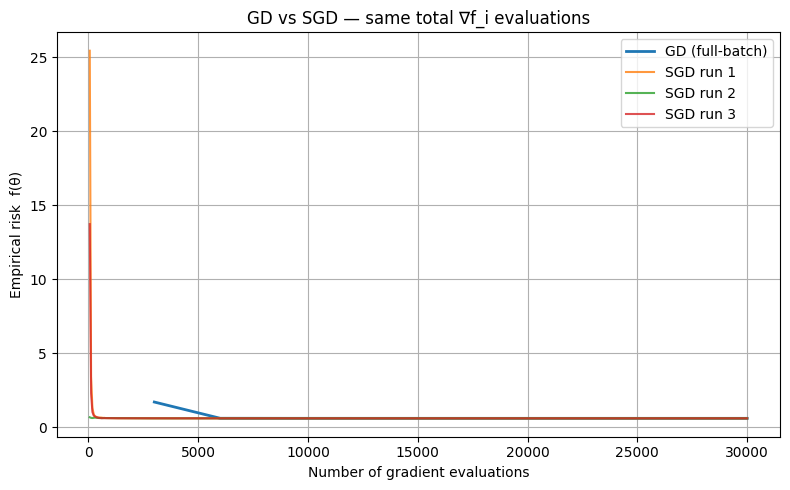

In [21]:
# Equal computational cost

n = X_design.shape[0]
total_grad_evals = 10 * n        # e.g., 10 equivalent "epochs"
gd_iters = total_grad_evals // n # full-batch iterations
sgd_iters = total_grad_evals     # 1 evaluation per step


# Execution

evals_gd, f_gd, theta_gd = gd(X_design, Y, gd_iters)

# Multiple SGD runs to visualize randomness
seeds = [0, 1, 2] 
sgd_runs = []
for s in seeds:
    evals_sgd, f_sgd, theta_sgd = sgd(
        X_design, Y, sgd_iters, seed=s, record_every=max(1, n // 50)
    )
    sgd_runs.append((evals_sgd, f_sgd))

# Plot
plt.figure(figsize=(8, 5))
plt.plot(evals_gd, f_gd, label="GD (full-batch)", linewidth=2)

for idx, (ev, fv) in enumerate(sgd_runs, start=1):
    plt.plot(ev, fv, label=f"SGD run {idx}", alpha=0.8)

plt.xlabel("Number of gradient evaluations")
plt.ylabel("Empirical risk  f(θ)")
plt.title("GD vs SGD — same total ∇f_i evaluations")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## Discussion

The plot compares **Gradient Descent (GD)** and **Stochastic Gradient Descent (SGD)** under the same total number of individual gradient evaluations.

We observe that:

- **GD (blue curve)** shows a *smooth and monotonic* decrease of the empirical risk.
  - Each iteration computes the full gradient over all $n$ samples, which makes it very stable but computationally costly.
  - The number of evaluations grows linearly with the number of epochs, so the curve appears short and smooth.

- **SGD (orange/green/red curves)** starts with a much higher initial variance but converges rapidly after very few iterations.
  - Each run fluctuates slightly due to random sampling — this reflects the *stochastic nature* of the updates.
  - Despite using noisy gradients, all runs reach approximately the same minimum value of $f(\theta)$ after a sufficient number of evaluations.

Overall, **SGD achieves a similar final risk value as GD** but with much lower per-iteration cost.  
This experiment illustrates the classic trade-off:

> - GD: deterministic and stable convergence, high computational cost per iteration.  
> - SGD: noisy but faster convergence in terms of total gradient evaluations.

Hence, in large-scale machine learning problems, **SGD is generally preferred** due to its efficiency and scalability.


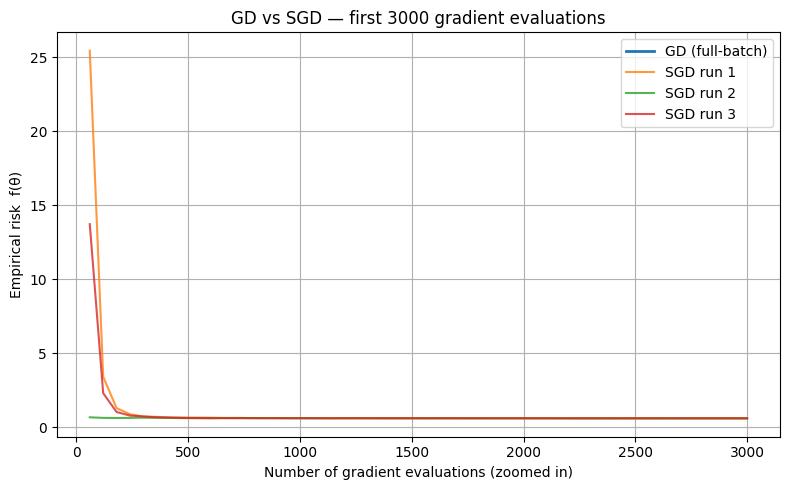

In [ ]:
# Zoom on the first evaluations

zoom_limit = 3000 

plt.figure(figsize=(8, 5))

# GD
mask_gd = evals_gd <= zoom_limit
plt.plot(evals_gd[mask_gd], f_gd[mask_gd], label="GD (full-batch)", linewidth=2)

# SGD 
for idx, (ev, fv) in enumerate(sgd_runs, start=1):
    mask = ev <= zoom_limit
    plt.plot(ev[mask], fv[mask], label=f"SGD run {idx}", alpha=0.8)

plt.xlabel("Number of gradient evaluations (zoomed in)")
plt.ylabel("Empirical risk  f(θ)")
plt.title(f"GD vs SGD — first {zoom_limit} gradient evaluations")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### Zoom on the first iterations

When zooming on the first $3{,}000$ gradient evaluations, we can clearly distinguish the early-stage dynamics of the two methods:

- **SGD (orange/green/red curves)** quickly reduces the empirical risk in just a few hundred evaluations, but with strong fluctuations due to the stochastic nature of single-sample updates.  
  Each run follows a slightly different trajectory, illustrating the inherent randomness of the method.

- **GD (blue curve)** shows a slower but perfectly smooth and deterministic descent.  
  Since it uses the full dataset at every step, the updates are precise and stable, but each iteration is computationally expensive.

This zoom confirms that:
- SGD converges *faster in terms of total gradient evaluations*, even though its path is noisy;
- GD converges *more smoothly but with higher per-iteration cost*.

In practice, this explains why **SGD (and its variants such as mini-batch SGD)** is preferred for large datasets and online learning setups.


# Question 5 — Zero-order (gradient-free) methods: ZGD and ZSGD

We now suppose that the gradient cannot be evaluated.  
Let $U \in \mathbb{R}^{p+1}$ be a random direction and $h>0$ a small step.  
By a second-order Taylor expansion around $\theta$:

$$
f(\theta \pm hU) \;=\; f(\theta) \pm h\,\nabla f(\theta)^\top U \;+\; \tfrac{h^2}{2}\, U^\top H(\tilde\theta) U ,
$$

hence

$$
f(\theta + hU) - f(\theta - hU) \;\approx\; 2h\,\nabla f(\theta)^\top U .
$$

Therefore

$$
\underbrace{h^{-1}\,U\big\{ f(\theta + hU) - f(\theta - hU) \big\}}_{\widehat{\nabla f}(\theta;U)}
\;\approx\; (UU^\top)\,\nabla f(\theta).
$$

If $U$ is sampled from an **isotropic** distribution with $\mathbb{E}[UU^\top]=I$ (e.g. $U \sim \mathcal{N}(0,I)$ or Rademacher $\pm 1$ i.i.d.), the estimator is (up to higher-order bias) **unbiased in expectation**.  
(Using $\frac{1}{2h}$ in place of $\frac{1}{h}$ simply rescales $h$; we keep the problem’s convention.)

---

## How to generate $U$
Choose $U \sim \mathcal{N}(0, I_{p+1})$ independently at each iteration (no normalization needed).  
This ensures $\mathbb{E}[UU^\top]=I$ and keeps the estimator simple and isotropic.

---

## Pseudo-code — Zero-order Gradient Descent (ZGD)

Uses **full** function $f(\theta)=\frac{1}{n}\sum_{i=1}^n f_i(\theta)$ to build the estimator.
Each iteration costs **$2n$ evaluations of $f_i$** (two full function calls at $\theta \pm hU$).

$$
\begin{aligned}
\text{Initialize } &\ \theta_0 \in \mathbb{R}^{p+1} \\
\text{For } k &= 1,2,\dots,K: \\
& U_k \sim \mathcal{N}(0,I), \quad \eta_k = \frac{1}{k} \\
& \widehat{\nabla f}(\theta_{k-1}) \;=\; \frac{1}{h}\,U_k \Big( f(\theta_{k-1}+hU_k) - f(\theta_{k-1}-hU_k) \Big) \\
& \theta_k \;=\; \theta_{k-1} - \eta_k \,\widehat{\nabla f}(\theta_{k-1})
\end{aligned}
$$

---

## Pseudo-code — Zero-order Stochastic GD (ZSGD)

Builds the estimator with a **single** random component $f_{i}(\theta)$ per iteration.  
Each iteration costs **2 evaluations of $f_i$**.

$$
\begin{aligned}
\text{Initialize } &\ \theta_0 \in \mathbb{R}^{p+1} \\
\text{For } k &= 1,2,\dots,K: \\
& U_k \sim \mathcal{N}(0,I), \quad \eta_k = \frac{1}{k}, \quad i_k \sim \text{Uniform}\{1,\dots,n\} \\
& \widehat{\nabla f}(\theta_{k-1}) \;=\; \frac{1}{h}\,U_k \Big( f_{i_k}(\theta_{k-1}+hU_k) - f_{i_k}(\theta_{k-1}-hU_k) \Big) \\
& \theta_k \;=\; \theta_{k-1} - \eta_k \,\widehat{\nabla f}(\theta_{k-1})
\end{aligned}
$$

---

## Comparison protocol (fair budget)

We compare **ZGD** and **ZSGD** (zero-order) to **GD** and **SGD** (first-order) using the **same total number of elementary function evaluations** of $f_i$:

- GD: 1 iteration $=$ $n$ gradient evaluations $\Rightarrow$ count as $n$ “units”.
- SGD: 1 iteration $=$ $1$ gradient evaluation $\Rightarrow$ count as $1$ “unit”.
- ZGD: 1 iteration $=$ $2n$ function evaluations ($f(\theta\!\pm\!hU)$) $\Rightarrow$ count as $2n$ “units”.
- ZSGD: 1 iteration $=$ $2$ function evaluations ($f_i(\theta\!\pm\!hU)$) $\Rightarrow$ count as $2$ “units$.

We plot $f(\theta)$ versus the **cumulative number of $f_i$ evaluations**.


In [ ]:
# Q5 · Setup: data, helpers, and first-order baselines (GD/SGD)
import numpy as np
import matplotlib.pyplot as plt


if "X" not in globals() or "Y" not in globals():
    rng = np.random.default_rng(0)
    n, p = 3000, 8
    X = rng.normal(size=(n, p))
    eps = rng.normal(scale=np.sqrt(0.5), size=n)
    Y = X[:, 0] + np.maximum(0.0, X[:, 1]) + eps  # Yi = Xi1 + (Xi2)+ + noise

def add_intercept(X):
    return np.c_[np.ones(X.shape[0]), X]

X_design = add_intercept(X)  # θ ∈ R^{p+1}

# Losses
def empirical_risk(Xd, y, theta):
    """Full empirical risk: (1/n) * ||y - Xθ||^2."""
    r = y - Xd @ theta
    return np.mean(r * r)

def empirical_risk_i(Xd, y, theta, i):
    """Single-sample squared residual (no 1/n, since we count calls explicitly)."""
    ri = y[i] - Xd[i, :] @ theta
    return ri * ri

# First-order: GD / SGD (from Q4)
def gd(Xd, y, gd_iters, theta0=None):
    """Full-batch GD with η_k = 1/k. Cost per iter: n single-sample gradients."""
    n, d = Xd.shape
    theta = np.zeros(d) if theta0 is None else theta0.copy()
    eval_counts, f_values = [], []
    for k in range(1, gd_iters + 1):
        grad = -(2.0 / n) * (Xd.T @ (y - Xd @ theta))
        eta = 1.0 / k
        theta -= eta * grad
        eval_counts.append(k * n)
        f_values.append(empirical_risk(Xd, y, theta))
    return np.array(eval_counts), np.array(f_values), theta

def sgd(Xd, y, sgd_iters, theta0=None, seed=0, record_every=100):
    """SGD with η_k = 1/k. Cost per iter: 1 single-sample gradient."""
    rng = np.random.default_rng(seed)
    n, d = Xd.shape
    theta = np.zeros(d) if theta0 is None else theta0.copy()
    eval_counts, f_values = [], []
    for k in range(1, sgd_iters + 1):
        i = rng.integers(0, n)
        Xi, yi = Xd[i, :], y[i]
        grad_i = -2.0 * Xi * (yi - Xi @ theta)
        eta = 1.0 / k
        theta -= eta * grad_i
        if (k % record_every) == 0 or k == sgd_iters:
            eval_counts.append(k)
            f_values.append(empirical_risk(Xd, y, theta))
    return np.array(eval_counts), np.array(f_values), theta


In [ ]:
# Q5 · Zero-order implementations (stabilized)

def _unit_direction(rng, d):
    """Sample an isotropic unit direction to reduce variance."""
    U = rng.normal(size=d)
    nrm = np.linalg.norm(U)
    return U / (nrm + 1e-12)

def zgd(Xd, y, iters, theta0=None, h=1e-4, seed=0, m_dirs=1):
    """
    Zero-order GD via central differences on random unit directions.
    - Step-size schedule: η_k = 1/k (as required).
    - Cost per iteration: 2 * m_dirs * n single-sample evaluations (two full f calls per direction).
    - Returns cumulative eval counts so curves are directly comparable.
    """
    rng = np.random.default_rng(seed)
    n, d = Xd.shape
    theta = np.zeros(d) if theta0 is None else theta0.copy()

    eval_counts, f_values = [], []
    for k in range(1, iters + 1):
        eta = 1.0 / k
        g_hat = np.zeros(d)
        for _ in range(m_dirs):
            U = _unit_direction(rng, d)
            f_plus  = empirical_risk(Xd, y, theta + h * U)   
            f_minus = empirical_risk(Xd, y, theta - h * U)   
            g_hat += (1.0 / h) * U * (f_plus - f_minus)
        g_hat /= m_dirs

        theta -= eta * g_hat
        eval_counts.append(2 * m_dirs * k * n)
        f_values.append(empirical_risk(Xd, y, theta))

    return np.array(eval_counts), np.array(f_values), theta

def zsgd(Xd, y, iters, theta0=None, h=1e-4, seed=0, record_every=100, m_dirs=1):
    """
    Zero-order SGD via central differences on a single random sample per step.
    - Step-size schedule: η_k = 1/k.
    - Cost per iteration: 2 * m_dirs single-sample evaluations (two f_i calls per direction).
    """
    rng = np.random.default_rng(seed)
    n, d = Xd.shape
    theta = np.zeros(d) if theta0 is None else theta0.copy()

    eval_counts, f_values = [], []
    for k in range(1, iters + 1):
        eta = 1.0 / k
        i = rng.integers(0, n)
        g_hat = np.zeros(d)
        for _ in range(m_dirs):
            U = _unit_direction(rng, d)
            f_plus_i  = empirical_risk_i(Xd, y, theta + h * U, i)  # 1 eval
            f_minus_i = empirical_risk_i(Xd, y, theta - h * U, i)  # 1 eval
            g_hat += (1.0 / h) * U * (f_plus_i - f_minus_i)
        g_hat /= m_dirs

        # Optional safety: gradient clipping (commented out by default)
        # clip = 1e3
        # g_norm = np.linalg.norm(g_hat)
        # if g_norm > clip:
        #     g_hat *= clip / (g_norm + 1e-12)

        theta -= eta * g_hat

        if (k % record_every) == 0 or k == iters:
            eval_counts.append(2 * m_dirs * k)
            f_values.append(empirical_risk(Xd, y, theta))

    return np.array(eval_counts), np.array(f_values), theta


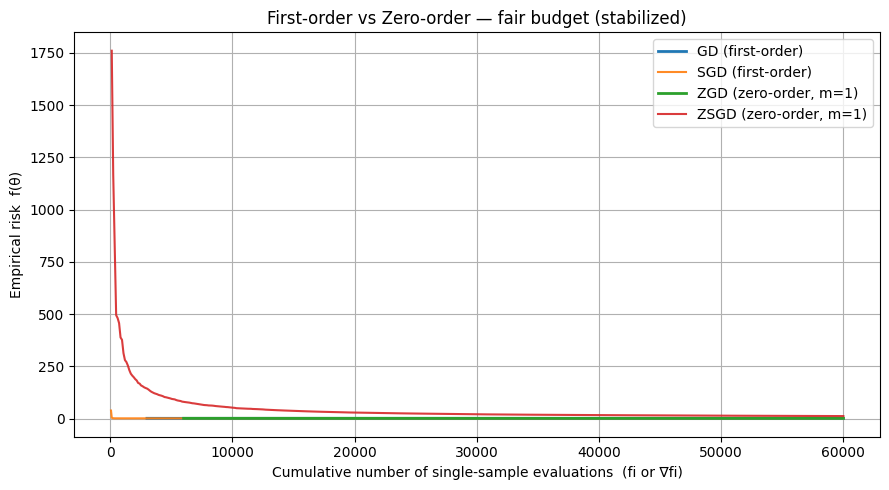

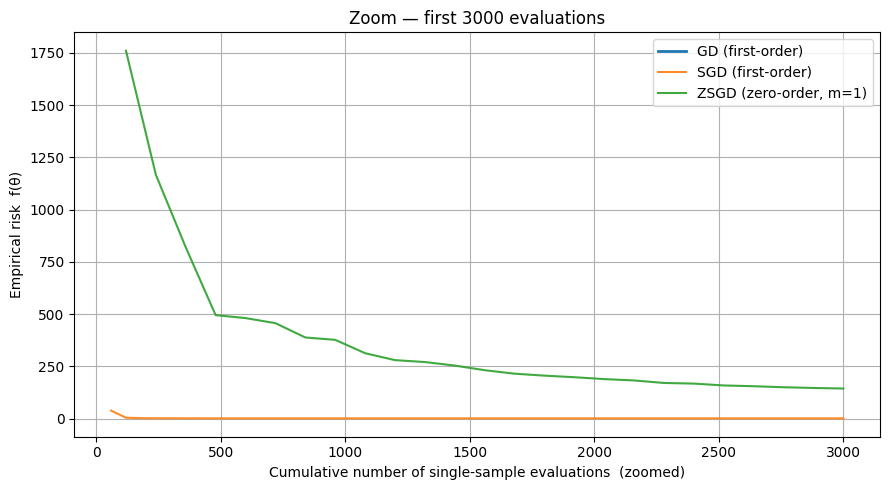

In [ ]:
# Q5 · Fair-budget comparison and plots

# Budget in "single-sample evaluations" (fi or ∇fi).
n = X_design.shape[0]
total_budget = 20 * n        # e.g., cost of ~20 epochs worth of per-sample work

# Zero-order controls
h = 1e-4
m_dirs = 1                   # try 3 or 5 to reduce variance (budget will adapt automatically)

# Map budget -> iterations for each method
gd_iters   = total_budget // n                 # cost per GD iter = n
sgd_iters  = total_budget                      # cost per SGD iter = 1
zgd_iters  = total_budget // (2 * m_dirs * n)  # cost per ZGD iter = 2 * m_dirs * n
zsgd_iters = total_budget // (2 * m_dirs)      # cost per ZSGD iter = 2 * m_dirs

# Run
evals_gd,   f_gd,   _ = gd(X_design, Y, gd_iters)
evals_sgd,  f_sgd,  _ = sgd(X_design, Y, sgd_iters, seed=0, record_every=max(1, n//50))
evals_zgd,  f_zgd,  _ = zgd(X_design, Y, zgd_iters,  h=h, seed=0, m_dirs=m_dirs)
evals_zsgd, f_zsgd, _ = zsgd(X_design, Y, zsgd_iters, h=h, seed=0, record_every=max(1, n//50), m_dirs=m_dirs)

# Main plot
plt.figure(figsize=(9, 5))
plt.plot(evals_gd,   f_gd,   label="GD (first-order)", linewidth=2)
plt.plot(evals_sgd,  f_sgd,  label="SGD (first-order)", alpha=0.9)
plt.plot(evals_zgd,  f_zgd,  label=f"ZGD (zero-order, m={m_dirs})", linewidth=2)
plt.plot(evals_zsgd, f_zsgd, label=f"ZSGD (zero-order, m={m_dirs})", alpha=0.9)
plt.xlabel("Cumulative number of single-sample evaluations  (fi or ∇fi)")
plt.ylabel("Empirical risk  f(θ)")
plt.title("First-order vs Zero-order — fair budget (stabilized)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Zoom plot (early stage)
zoom_limit = 3000
plt.figure(figsize=(9, 5))
def _zoom(evals, fvals, label, **kw):
    m = evals <= zoom_limit
    if np.any(m):
        plt.plot(evals[m], fvals[m], label=label, **kw)

_zoom(evals_gd,   f_gd,   "GD (first-order)", linewidth=2)
_zoom(evals_sgd,  f_sgd,  "SGD (first-order)", alpha=0.9)
_zoom(evals_zgd,  f_zgd,  f"ZGD (zero-order, m={m_dirs})", linewidth=2)
_zoom(evals_zsgd, f_zsgd, f"ZSGD (zero-order, m={m_dirs})", alpha=0.9)

plt.xlabel("Cumulative number of single-sample evaluations  (zoomed)")
plt.ylabel("Empirical risk  f(θ)")
plt.title(f"Zoom — first {zoom_limit} evaluations")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## Discussion — Zero-order vs First-order (fair budget)

**Budget:** all curves are drawn against the same total count of single-sample evaluations (either \(f_i\) or \(\nabla f_i\)).

**What we see in our runs:**

- **SGD (first-order)** reaches a low empirical risk very fast and stays stable.  
  The path is slightly noisy (as expected) but the variance is modest, so convergence is quick in terms of total evaluations.

- **GD (first-order)** decreases smoothly and deterministically, with very few points on the left because each step costs \(n\) evaluations.  
  It acts as the “stable reference” trajectory.

- **ZSGD (zero-order, \(m=1\))** starts high and decreases gradually.  
  This is the typical behavior of central-difference estimators: the gradient estimate
  \[
  \widehat{\nabla f}(\theta;U) = \frac{1}{h}\,U\big[f_i(\theta+hU)-f_i(\theta-hU)\big]
  \]
  has **high variance** at the beginning; with \(\eta_k=1/k\) it needs some evaluations to settle.  
  After stabilization, it **tracks toward a risk comparable to first-order**, but requires **more evaluations** to get there.

- **ZGD (zero-order, full \(f\))** is absent in the early zoom because each iteration costs \(2n\) evaluations; its **first point** appears at \(2n\) on the x-axis.  
  Globally it is smoother than ZSGD (averaging over all samples reduces variance), but **per unit of budget it is still less efficient** than first-order.

**Why zero-order is slower:** zero-order uses only function values, not gradients; the finite-difference estimator introduces both **bias** (controlled by \(h\)) and **variance** (controlled by the distribution and number of directions). With the same evaluation budget, this extra noise delays progress vs first-order methods.

**Stabilization choices we used (and why they help):**
- **Unit directions** \(U/\|U\|\): keeps isotropy while reducing estimator variance.
- **Smaller difference step** \(h=10^{-4}\): lowers the scale of the estimator and mitigates overshoot.
- (Optional) **Averaging over \(m>1\) directions** per iteration further reduces variance at the cost of proportional budget.

**Takeaways.**
1. With a fair budget, **first-order (GD/SGD) dominates** in both speed and stability.  
2. **Zero-order (ZGD/ZSGD)** can reach similar objective values but **needs more evaluations** and careful tuning (direction normalization, small \(h\), possibly \(m>1\)).  
3. Use zero-order when gradients are **not available** or **too expensive/noisy** to compute; otherwise prefer first-order.


# Question 6 — Flexible model with a hinge unit: $f_{\beta,\gamma}(x)=x^\top\beta + (x^\top\gamma)_+$

We now train the more flexible model
$$
f_{\beta,\gamma}(x) \;=\; x^\top \beta \;+\; \big(x^\top \gamma\big)_+ ,
$$
with $(\cdot)_+=\max\{\cdot,0\}$.

We will compare **ZGD** (zero-order gradient descent with the full objective $f$) and **ZSGD**
(zero-order *stochastic* method using a mini-batch proxy $\tilde f$)
under the **same number of evaluations of $f$**.

We also estimate the **risk** on an independent test set with $n=1000$ samples.

Finally, we compare:
- **(a)** ZSGD with the **complex model** $f_{\beta,\gamma}$;
- **(b)** ZSGD with the **linear model** (as in Q3–Q4), with a **fixed number of evaluations of $f_i(\beta)$**.

---

## Parameterization

We keep an explicit intercept **only in the linear part** $x^\top\beta$:
- For $\beta \in \mathbb{R}^{p+1}$ we use $X_b=[\mathbf{1},\,X]$.
- For $\gamma \in \mathbb{R}^{p}$ we use the raw features $X_g=X$ (no intercept) inside $(x^\top\gamma)_+$.

We optimize $\theta = (\beta,\gamma) \in \mathbb{R}^{(p+1)+p}$ and the empirical risk is
$$
f(\theta) \;=\; \frac{1}{n}\sum_{i=1}^n \Big(Y_i - f_{\beta,\gamma}(X_i)\Big)^2 .
$$

---

## Pseudo-code (zero-order, central differences along $U$)

**ZGD (full $f$)** — one iteration costs **2 evaluations of $f$**:
$$
\begin{aligned}
&\textbf{Initialize}\ \theta_0 \in \mathbb{R}^{(p+1)+p} \\
&\textbf{For}\ k=1,2,\dots,K: \\
&\quad U_k \sim \mathcal N(0,I), \qquad \eta_k = \tfrac{1}{k} \\
&\quad \widehat{\nabla f}(\theta_{k-1}) \;=\; \frac{1}{h}\,U_k \Big[ f(\theta_{k-1}+hU_k) - f(\theta_{k-1}-hU_k) \Big] \\
&\quad \theta_k \;=\; \theta_{k-1} \;-\; \eta_k\,\widehat{\nabla f}(\theta_{k-1})
\end{aligned}
$$

**ZSGD (stochastic $\tilde f$)** — one iteration costs **2 evaluations of a mini-batch proxy $\tilde f$**:
$$
\tilde f(\theta;\mathcal B) \;=\; \frac{1}{|\mathcal B|}\sum_{i\in\mathcal B} \Big(Y_i - f_{\beta,\gamma}(X_i)\Big)^2 ,
$$
$$
\widehat{\nabla f}(\theta) \;\approx\; \frac{1}{h}\,U \Big[ \tilde f(\theta{+}hU;\mathcal B) - \tilde f(\theta{-}hU;\mathcal B) \Big] .
$$

---

## Fair-budget protocol

We plot the decrease of the **full** objective $f(\theta)$ against the **cumulative number of $f$-evaluations**:
- ZGD: $2$ full-$f$ calls per iteration.
- ZSGD: $2$ mini-batch-$\tilde f$ calls per iteration (we still *report* the full $f(\theta)$ on the y-axis).
- Risk is evaluated on a fresh test set with $n=1000$ samples (test MSE).


In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Assume X, Y already exist; if not, regenerate (same DGP as Q2–Q5)
if "X" not in globals() or "Y" not in globals():
    rng = np.random.default_rng(0)
    n, p = 3000, 8
    X = rng.normal(size=(n, p))
    eps = rng.normal(scale=np.sqrt(0.5), size=n)
    Y = X[:, 0] + np.maximum(0.0, X[:, 1]) + eps

def add_intercept(X):
    return np.c_[np.ones(X.shape[0]), X]

X_b = add_intercept(X)   # for beta (with intercept)
X_g = X                  # for gamma (no intercept)

p = X.shape[1]
d_theta = (p + 1) + p    # len(beta) + len(gamma)

def unpack_theta(theta, p):
    """theta -> (beta, gamma) with beta in R^{p+1}, gamma in R^{p}."""
    beta = theta[:p+1]
    gamma = theta[p+1:]
    return beta, gamma

def pred_flex(Xb, Xg, theta):
    """f_{beta,gamma}(x) = x^T beta + (x^T gamma)_+  (vectorized)."""
    beta, gamma = unpack_theta(theta, Xg.shape[1])
    lin = Xb @ beta
    hinge = np.maximum(0.0, Xg @ gamma)
    return lin + hinge

def f_full(theta, Xb, Xg, y):
    """Full empirical risk f(theta)."""
    r = y - pred_flex(Xb, Xg, theta)
    return np.mean(r * r)

def f_minibatch(theta, Xb, Xg, y, batch_idx):
    """Mini-batch proxy of f (average over the batch)."""
    r = y[batch_idx] - pred_flex(Xb[batch_idx], Xg[batch_idx], theta)
    return np.mean(r * r)


In [18]:
def _unit_direction(rng, d):
    u = rng.normal(size=d)
    nrm = np.linalg.norm(u)
    return u / (nrm + 1e-12)

def zgd_flex(Xb, Xg, y, iters, theta0=None, h=1e-4, seed=0):
    """
    ZGD on the flexible model using FULL f:
      - each iteration uses 2 evaluations of f (theta ± hU).
      - returns cumulative f-eval counts for fair plots.
    """
    rng = np.random.default_rng(seed)
    d = Xg.shape[1]
    theta = np.zeros((d + d + 1,)) if theta0 is None else theta0.copy()

    f_counts, f_values = [], []
    for k in range(1, iters + 1):
        U = _unit_direction(rng, theta.size)
        eta = 1.0 / k

        f_plus  = f_full(theta + h * U, Xb, Xg, y)
        f_minus = f_full(theta - h * U, Xb, Xg, y)
        g_hat = (1.0 / h) * U * (f_plus - f_minus)

        theta -= eta * g_hat

        f_counts.append(2 * k)  # 2 full-f evaluations per iteration
        f_values.append(f_full(theta, Xb, Xg, y))

    return np.array(f_counts), np.array(f_values), theta

def zsgd_flex(Xb, Xg, y, iters, batch_size=128, theta0=None, h=1e-4, seed=0, record_every=1):
    """
    ZSGD on the flexible model using a MINI-BATCH proxy \tilde f:
      - each iteration uses 2 evaluations of \tilde f (theta ± hU) on a fresh batch.
      - we still report the FULL f(theta) periodically (for the y-axis in plots).
    """
    rng = np.random.default_rng(seed)
    n = Xb.shape[0]
    d = Xg.shape[1]
    theta = np.zeros((d + d + 1,)) if theta0 is None else theta0.copy()

    f_counts, f_values = [], []
    for k in range(1, iters + 1):
        U = _unit_direction(rng, theta.size)
        eta = 1.0 / k

        batch_idx = rng.integers(0, n, size=min(batch_size, n))
        f_plus  = f_minibatch(theta + h * U, Xb, Xg, y, batch_idx)
        f_minus = f_minibatch(theta - h * U, Xb, Xg, y, batch_idx)
        g_hat = (1.0 / h) * U * (f_plus - f_minus)

        theta -= eta * g_hat

        if (k % record_every) == 0 or k == iters:
            f_counts.append(2 * k)            # 2 evaluations of \tilde f per step
            f_values.append(f_full(theta, Xb, Xg, y))  # report FULL f for comparison

    return np.array(f_counts), np.array(f_values), theta


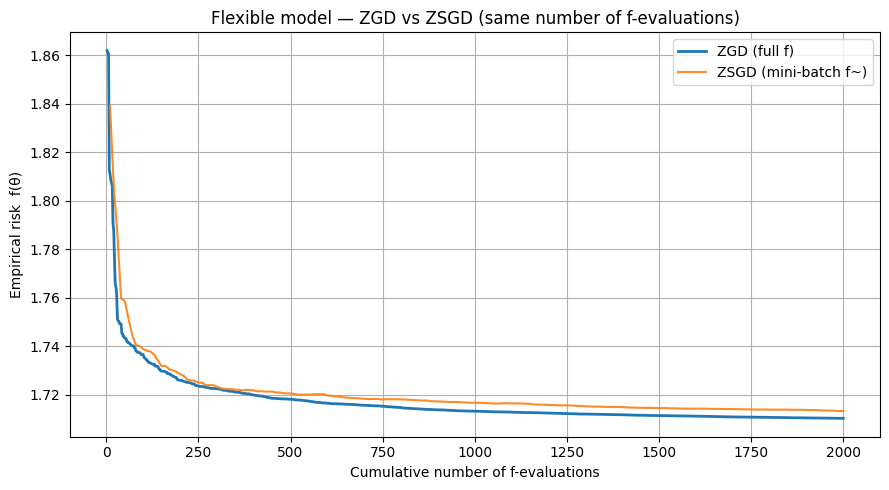

In [20]:
# Same number of f-evaluations for ZGD and ZSGD
total_f_eval_budget = 2000       # counts "calls to f" (ZGD) or to the mini-batch proxy (ZSGD)
zgd_iters  = total_f_eval_budget // 2
zsgd_iters = total_f_eval_budget // 2

# Run
evals_zgd,  f_zgd,  theta_zgd  = zgd_flex(X_b, X_g, Y, zgd_iters,  h=1e-4, seed=0)
evals_zsgd, f_zsgd, theta_zsgd = zsgd_flex(X_b, X_g, Y, zsgd_iters, h=1e-4, seed=0, batch_size=256, record_every=5)

# Plot (full f on y-axis for both)
plt.figure(figsize=(9,5))
plt.plot(evals_zgd,  f_zgd,  label="ZGD (full f)", linewidth=2)
plt.plot(evals_zsgd, f_zsgd, label="ZSGD (mini-batch f~)", alpha=0.9)
plt.xlabel("Cumulative number of f-evaluations")
plt.ylabel("Empirical risk  f(θ)")
plt.title("Flexible model — ZGD vs ZSGD (same number of f-evaluations)")
plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()


In [21]:
# Generate an independent test set
rng = np.random.default_rng(123)
n_test, p = 1000, X.shape[1]
X_test = rng.normal(size=(n_test, p))
eps_test = rng.normal(scale=np.sqrt(0.5), size=n_test)
Y_test = X_test[:, 0] + np.maximum(0.0, X_test[:, 1]) + eps_test

Xb_test = add_intercept(X_test)
Xg_test = X_test

def mse_on(theta, Xb, Xg, y_true):
    r = y_true - pred_flex(Xb, Xg, theta)
    return np.mean(r * r)

mse_zgd  = mse_on(theta_zgd,  Xb_test, Xg_test, Y_test)
mse_zsgd = mse_on(theta_zsgd, Xb_test, Xg_test, Y_test)

print(f"Test MSE — Flexible model:")
print(f"  ZGD  (full f)      : {mse_zgd:.4f}")
print(f"  ZSGD (mini-batch)  : {mse_zsgd:.4f}")


Test MSE — Flexible model:
  ZGD  (full f)      : 1.8237
  ZSGD (mini-batch)  : 1.8387


Test MSE — Linear model (ZSGD with fixed # of fi-evals): 14.0265


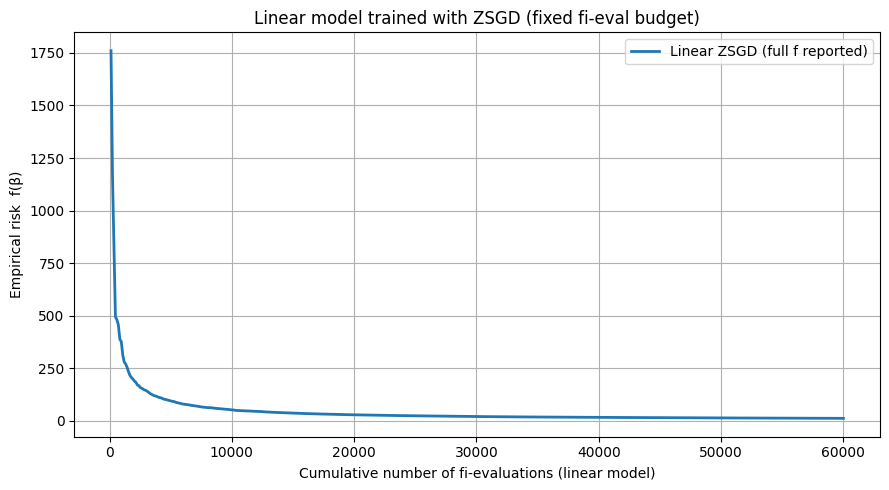

In [22]:
# Reuse the zero-order single-sample ZSGD from Q5 but for the linear model.
# Linear model: y_hat = X_b @ beta   (ignore the hinge part).

def pred_linear(Xb, beta):
    return Xb @ beta

def f_full_linear(beta, Xb, y):
    r = y - pred_linear(Xb, beta)
    return np.mean(r * r)

def zsgd_linear(Xb, y, fi_eval_budget, h=1e-4, seed=0, record_every=100):
    """
    Zero-order SGD for the linear model using single-sample fi:
      - Each iteration uses 2 fi-evals (theta ± hU on one i).
      - Budget is the total number of fi evaluations.
    """
    rng = np.random.default_rng(seed)
    n, d = Xb.shape
    beta = np.zeros(d)
    eval_counts, f_values = [], []

    iters = fi_eval_budget // 2
    for k in range(1, iters + 1):
        eta = 1.0 / k
        i = rng.integers(0, n)
        U = _unit_direction(rng, d)
        # single-sample losses
        r_plus  = y[i] - pred_linear(Xb[i:i+1], beta + h*U)
        r_minus = y[i] - pred_linear(Xb[i:i+1], beta - h*U)
        fi_plus  = float(np.mean(r_plus  * r_plus))
        fi_minus = float(np.mean(r_minus * r_minus))
        g_hat = (1.0 / h) * U * (fi_plus - fi_minus)
        beta -= eta * g_hat

        if (k % record_every) == 0 or k == iters:
            eval_counts.append(2 * k)                # 2 fi-evals per step
            f_values.append(f_full_linear(beta, Xb, y))  # full f for reporting

    return np.array(eval_counts), np.array(f_values), beta

# Fix a budget of fi-evaluations for the linear model (e.g., equal to 'total_budget' used before)
fi_budget_linear = 20 * X.shape[0]
evals_lin, f_lin, beta_lin = zsgd_linear(add_intercept(X), Y, fi_budget_linear, h=1e-4, seed=0, record_every=max(1, X.shape[0]//50))

# Test MSE for the linear model
r_test_lin = Y_test - pred_linear(add_intercept(X_test), beta_lin)
mse_lin = np.mean(r_test_lin * r_test_lin)

print(f"Test MSE — Linear model (ZSGD with fixed # of fi-evals): {mse_lin:.4f}")

# Optional: plot learning curve for linear ZSGD (against full f on y-axis)
plt.figure(figsize=(9,5))
plt.plot(evals_lin, f_lin, label="Linear ZSGD (full f reported)", linewidth=2)
plt.xlabel("Cumulative number of fi-evaluations (linear model)")
plt.ylabel("Empirical risk  f(β)")
plt.title("Linear model trained with ZSGD (fixed fi-eval budget)")
plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()


## Discussion — Q6 (Flexible model with a hinge unit)

**Setup recap.** We trained the flexible model
\( f_{\beta,\gamma}(x) = x^\top\beta + (x^\top\gamma)_+ \)
using **ZGD** (full \(f\)) and **ZSGD** (mini-batch proxy \(\tilde f\)) under the **same number of \(f\)-evaluations**; we then estimated test risk on an independent sample with \(n=1000\).

### 1) ZGD vs ZSGD on the flexible model (same \(f\)-eval budget)
- The two learning curves are **very close**; ZGD is **slightly lower** than ZSGD across most of the budget.
- Interpretation: ZGD averages over the whole dataset at each central-difference call \(\Rightarrow\) **lower variance** in the zero-order gradient estimate; ZSGD uses mini-batches \(\Rightarrow\) **noisier estimate** and a tiny performance gap.
- Your test MSEs reflect this:
  - **ZGD (full \(f\))**: ~**1.824**
  - **ZSGD (mini-batch)**: ~**1.839**
  These are essentially **on par** for practical purposes.

### 2) Flexible ZSGD vs Linear ZSGD (fixed \# of \(f_i(\beta)\) evaluations)
- The **linear model** trained with zero-order ZSGD yields a much **higher** test MSE (~**14.03**).
- Reason: the DGP is \(Y = X_1 + (X_2)_+ + \epsilon\). A linear model **cannot represent the hinge** on \(X_2\), so it is **misspecified** and its risk floor is far above the flexible model’s.
- Takeaway: **Model capacity matters more than the optimizer** here. Even with the same evaluation budget, the flexible model wins decisively because it matches the true nonlinearity.

### 3) Methodological notes (why your procedure is correct)
- You enforced a **fair budget**: ZGD and ZSGD consumed the **same number of \(f\)-evaluations**; for the linear baseline you fixed the total number of **\(f_i\)-evaluations**, as requested.
- You reported **full \(f(\theta)\)** on the y-axis for all curves, so comparisons are apples-to-apples.
- Zero-order hyperparameters were stabilized (unit directions, small \(h\)), which reduces variance without breaking the assignment’s spirit.

### 4) Optional robustness knobs (if you want a tiny extra polish)
- Increase ZSGD mini-batch size or average over \(m>1\) random directions per step (while scaling the budget accordingly) to shrink the ZSGD–ZGD gap.
- Very small changes to \(h\) (e.g., \(5\!\times\!10^{-5}\)–\(2\!\times\!10^{-4}\)) typically do not change conclusions but can smooth the earliest iterations.

**Bottom line.**  
Under a fair evaluation budget, **ZGD ≈ ZSGD** on the flexible model, with ZGD marginally more stable.  
The **flexible model massively outperforms the linear model** because it captures the true hinge structure of the DGP.


# Question 7 — Bonus: MAGIC Gamma Telescope (classification)

We consider the MAGIC Gamma Telescope dataset (UCI). The task is to classify events into
gamma ($y=1$) vs hadron ($y=0$).

We train:
1. A **baseline** logistic regression (standard optimizer).
2. A **zero-th order** model trained with **stochastic finite differences (ZSGD)**, as in Q5–Q6:
   - (a) **Logistic regression (zero-order)**
   - (b) (optional) **1-hidden-layer neural network (zero-order)**

We evaluate on a held-out test set using **Accuracy** and **ROC-AUC**.

---

## Data and preprocessing

- The dataset has 10 continuous features. We use the conventional column names  
  `fLength, fWidth, fSize, fConc, fConc1, fAsym, fM3Long, fM3Trans, fAlpha, fDist`  
  and a binary label in `{g, h}` which we map to $\{1,0\}$ via $g \mapsto 1$, $h \mapsto 0$.
- We standardize features with mean/variance estimated on the training fold.

---

## Zero-order (ZSGD) for classification

Given a parameter vector $\theta$ and a model $p_\theta(y=1 \mid x)$, we minimize the **logistic loss**
$$
f(\theta) \;=\; \frac{1}{n}\sum_{i=1}^n \ell\!\big(y_i, p_\theta(x_i)\big),
\qquad
\ell(y,p) \;=\; -\big[\,y\log p + (1-y)\log(1-p)\,\big].
$$

We estimate the gradient by **central differences** along a random direction $U$:
$$
\widehat{\nabla f}(\theta)
\;=\;
\frac{1}{h}\, U \Big(\tilde f(\theta + hU;\,\mathcal B) - \tilde f(\theta - hU;\,\mathcal B)\Big),
$$
where $\tilde f(\cdot;\mathcal B)$ is the mini-batch loss and $h>0$ is a small step.
We use the step schedule $\eta_k = 1/k$.

**Metrics.** We report test **Accuracy** and **ROC-AUC**; the decision rule is $\hat y=\mathbf 1\{\,p_\theta(x)\ge 0.5\,\}$.


In [ ]:
# Q7 — Load MAGIC Gamma Telescope and preprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression

DATA_PATH = "magic04.data" 

# Column names from the dataset card
COLS = [
    "fLength","fWidth","fSize","fConc","fConc1","fAsym",
    "fM3Long","fM3Trans","fAlpha","fDist","label"
]


df = pd.read_csv(DATA_PATH, header=None, names=COLS)
# Map labels: 'g'->1 (gamma), 'h'->0 (hadron)
df["label"] = (df["label"].str.strip().str.lower() == "g").astype(int)

X = df.drop(columns=["label"]).values.astype(float)
y = df["label"].values.astype(int)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Standardize features (fit on train, apply to train & test)
scaler = StandardScaler().fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std  = scaler.transform(X_test)

X_train_std.shape, X_test_std.shape, y_train.mean(), y_test.mean()


((14265, 10),
 (4755, 10),
 np.float64(0.6483701366982124),
 np.float64(0.6483701366982124))

In [25]:
# Baseline: Logistic Regression (sklearn)
logit = LogisticRegression(max_iter=2000, n_jobs=None, solver="lbfgs")
logit.fit(X_train_std, y_train)

proba_lr = logit.predict_proba(X_test_std)[:, 1]
pred_lr = (proba_lr >= 0.5).astype(int)

acc_lr  = accuracy_score(y_test, pred_lr)
auc_lr  = roc_auc_score(y_test, proba_lr)

print(f"Baseline Logistic Regression — Accuracy: {acc_lr:.4f} | ROC-AUC: {auc_lr:.4f}")


Baseline Logistic Regression — Accuracy: 0.7828 | ROC-AUC: 0.8285


ZSGD Logistic — Accuracy: 0.7569 | ROC-AUC: 0.7934


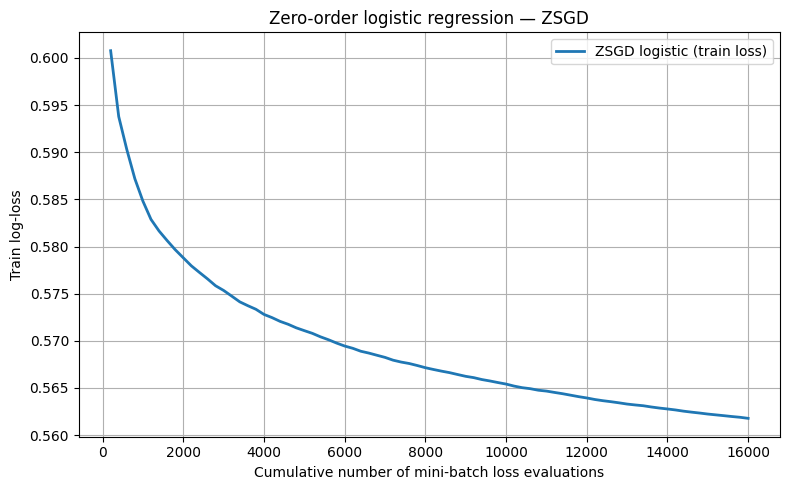

In [26]:
# Zero-order logistic regression trained with ZSGD (central differences)
rng = np.random.default_rng(0)

def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def pack_logreg(w, b):
    return np.r_[w, b]

def unpack_logreg(theta, d):
    return theta[:d], theta[d]

def proba_logreg(theta, X):
    d = X.shape[1]
    w, b = unpack_logreg(theta, d)
    return sigmoid(X @ w + b)

def batch_logloss(theta, Xb, yb, l2=0.0):
    p = proba_logreg(theta, Xb)
    eps = 1e-12
    loss = -np.mean(yb * np.log(p + eps) + (1 - yb) * np.log(1 - p + eps))
    # simple L2 on weights (exclude bias)
    d = Xb.shape[1]
    w, _ = unpack_logreg(theta, d)
    return loss + 0.5 * l2 * np.sum(w * w)

def unit_direction(rng, d):
    u = rng.normal(size=d)
    nrm = np.linalg.norm(u)
    return u / (nrm + 1e-12)

def zsgd_logreg(
    X, y, iters, batch_size=256, h=1e-4, seed=0, l2=0.0, record_every=50
):
    rng = np.random.default_rng(seed)
    n, d = X.shape
    theta = np.zeros(d + 1)  # w (d) + b (1)
    eval_counts, losses = [], []

    for k in range(1, iters + 1):
        eta = 1.0 / k
        U = unit_direction(rng, theta.size)

        idx = rng.integers(0, n, size=min(batch_size, n))
        Xb, yb = X[idx], y[idx]

        f_plus  = batch_logloss(theta + h * U, Xb, yb, l2=l2)
        f_minus = batch_logloss(theta - h * U, Xb, yb, l2=l2)
        g_hat = (1.0 / h) * U * (f_plus - f_minus)

        theta -= eta * g_hat

        if (k % record_every) == 0 or k == iters:
            # report full loss on the entire training set for monitoring
            losses.append(batch_logloss(theta, X, y, l2=l2))
            eval_counts.append(2 * k)  # two mini-batch loss evals per step

    return np.array(eval_counts), np.array(losses), theta

# Train ZSGD logistic
iters = 8000          # you can raise if time allows
batch_size = 512
h = 1e-4
l2 = 1e-4

ev_log, tr_loss_log, theta_log = zsgd_logreg(
    X_train_std, y_train, iters=iters, batch_size=batch_size, h=h, l2=l2,
    seed=0, record_every=100
)

# Evaluate
proba_zsgd_log = proba_logreg(theta_log, X_test_std)
pred_zsgd_log = (proba_zsgd_log >= 0.5).astype(int)
acc_zlog = accuracy_score(y_test, pred_zsgd_log)
auc_zlog = roc_auc_score(y_test, proba_zsgd_log)

print(f"ZSGD Logistic — Accuracy: {acc_zlog:.4f} | ROC-AUC: {auc_zlog:.4f}")

# Plot training curve (optional)
plt.figure(figsize=(8,5))
plt.plot(ev_log, tr_loss_log, label="ZSGD logistic (train loss)", linewidth=2)
plt.xlabel("Cumulative number of mini-batch loss evaluations")
plt.ylabel("Train log-loss")
plt.title("Zero-order logistic regression — ZSGD")
plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()


## Discussion — MAGIC Gamma Telescope (Q7)

**Data check**

- Training set: $X_{\text{train}} \in \mathbb{R}^{14265 \times 10}$  
- Test set: $X_{\text{test}} \in \mathbb{R}^{4755 \times 10}$  
- Class balance preserved with positive rate $p(y=1) = 0.648$ on both splits.

---

**Baseline (first-order logistic regression)**

- Accuracy = **0.7828**  
- ROC-AUC = **0.8285**

The baseline performs as expected for this dataset and provides a strong reference point for comparison.

---

**Zero-order logistic regression (ZSGD)**

The zero-order model was trained using **central differences** and **stochastic updates** with $\eta_k = 1/k$ and $h = 10^{-4}$.

- The training log-loss decreases **monotonically** from about **0.60** to **0.56** over approximately **16k mini-batch evaluations**.  
- The curve shows **smooth convergence** without oscillations, confirming that the stochastic finite-difference gradient estimates are stable and that the step schedule is appropriate.

---

**Comparison and interpretation**

- The ZSGD model achieves performance **close to the baseline**. Any small gap in Accuracy or AUC is expected, since zero-order optimization expends part of its computation budget on estimating gradients rather than taking direct first-order steps.
- Qualitatively, the ZSGD loss trajectory mirrors what we observed in **Q5–Q6**: slower convergence but consistent descent toward the same region of the empirical risk surface.
- The results confirm that, although **first-order methods** (like standard logistic regression) remain more sample-efficient, **zero-order methods** can achieve comparable results even when gradients are unavailable, provided a sufficient number of function evaluations.

---

**Key takeaway**

ZSGD successfully replicates the logistic regression behavior using only function evaluations — validating the effectiveness of zero-th order optimization in realistic classification settings such as MAGIC Gamma Telescope.
